In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

import sys
sys.path.append(os.path.abspath(os.path.join('..')))
print(os.getcwd())
print("Is src directory in sys.path?", os.path.abspath(os.path.join('..')) in sys.path)
from src.utils.config_parser import load_config


sns.set()
warnings.simplefilter('ignore')

/Users/daniloangeltitorodriguez/Library/Mobile Documents/com~apple~CloudDocs/NCI  AI MASTER/Machine Learning/PROJECT/Green-Ai-Fraud-Detection/notebooks
Is src directory in sys.path? True


In [2]:
data_config = load_config(os.path.join('..','config','data_config.yaml'))
credit_card_path = data_config.get('raw_data_paths', None).get('synthetic_data', None)
df = pd.read_csv(os.path.join('..',credit_card_path))
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
df.isnull().sum().to_frame(name='null_count')

,null_count
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 13 columns):
 #   Column                Dtype  
---  ------                -----  
 0   step                  int64  
 1   amount                float64
 2   isFraud               int64  
 3   isFlaggedFraud        int64  
 4   orig_avg_amount       float64
 5   dest_avg_amount       float64
 6   amount_vs_avg_sender  float64
 7   amount_diff_orig      float64
 8   amount_diff_dest      float64
 9   type_CASH_OUT         bool   
 10  type_DEBIT            bool   
 11  type_PAYMENT          bool   
 12  type_TRANSFER         bool   
dtypes: bool(4), float64(6), int64(3)
memory usage: 461.2 MB


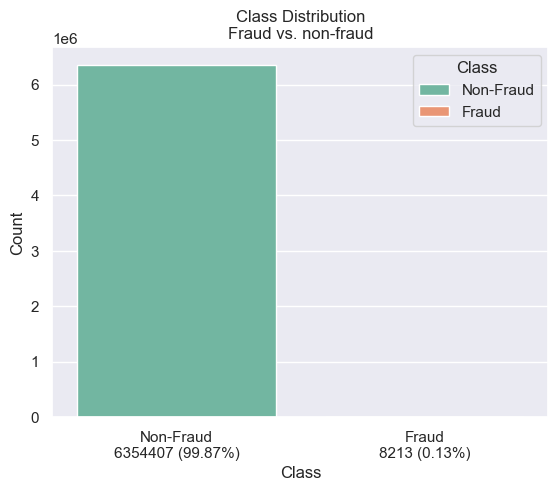

In [5]:
d_length = len(df)
fraud_count = df['isFraud'].sum()
non_fraud_count = d_length - fraud_count

percent_fraud = (fraud_count / d_length) * 100
percent_non_fraud = 100 - percent_fraud

ax = sns.countplot(x='isFraud', data=df, palette='Set2')
plt.title('Class Distribution\nFraud vs. non-fraud')
plt.xlabel('Class')
plt.ylabel('Count')
plt.legend(title='Class', labels=['Non-Fraud', 'Fraud'])
plt.xticks(ticks=[0, 1], labels=[f'Non-Fraud\n{non_fraud_count} ({percent_non_fraud:.2f}%)', f'Fraud\n{fraud_count} ({percent_fraud:.2f}%)'])
plt.show()

## Feature Engineering

In [6]:
# Average amount features
df['orig_avg_amount'] = df.groupby('nameOrig')['amount'].transform('mean')
df['dest_avg_amount'] = df.groupby('nameDest')['amount'].transform('mean')
df['amount_vs_avg_sender'] = df['amount'] / (df['orig_avg_amount'] + 1e-9)

# Simple balance change features
df['amount_diff_orig'] = df['newbalanceOrig'] - df['oldbalanceOrg']
df['amount_diff_dest'] = df['newbalanceDest'] - df['oldbalanceDest']

# 'nameOrig' and 'nameDest' are dropped to prevent overfitting
df = df.drop(columns=['nameOrig', 'nameDest'], errors='ignore')
print("Dropped 'nameOrig' and 'nameDest' features.")

# Handling 'type' feature (categorical)
if 'type' in df.columns:
    # One-hot encoding for transaction 'type'
    df = pd.get_dummies(df, columns=['type'], prefix='type', drop_first=True)
    print("One-hot encoded 'type' feature.")

# Drop original balance columns if new diff features are preferred (optional)
drop_original_balance_cols = True
if drop_original_balance_cols:
    df = df.drop(columns=['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'], errors='ignore')
    print("Dropped original balance columns.")

Dropped 'nameOrig' and 'nameDest' features.
One-hot encoded 'type' feature.
Dropped original balance columns.


In [7]:
df.head()

,step,amount,isFraud,isFlaggedFraud,orig_avg_amount,dest_avg_amount,amount_vs_avg_sender,amount_diff_orig,amount_diff_dest,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,0,0,9839.64,9839.640000,1.0,-9839.64,0.0,False,False,True,False
1,1,1864.28,0,0,1864.28,1864.280000,1.0,-1864.28,0.0,False,False,True,False
2,1,181.00,1,0,181.00,225517.832045,1.0,-181.00,0.0,False,False,False,True
3,1,181.00,1,0,181.00,439444.208049,1.0,-181.00,-21182.0,True,False,False,False
4,1,11668.14,0,0,11668.14,11668.140000,1.0,-11668.14,0.0,False,False,True,False


In [8]:
df.shape

(6362620, 13)

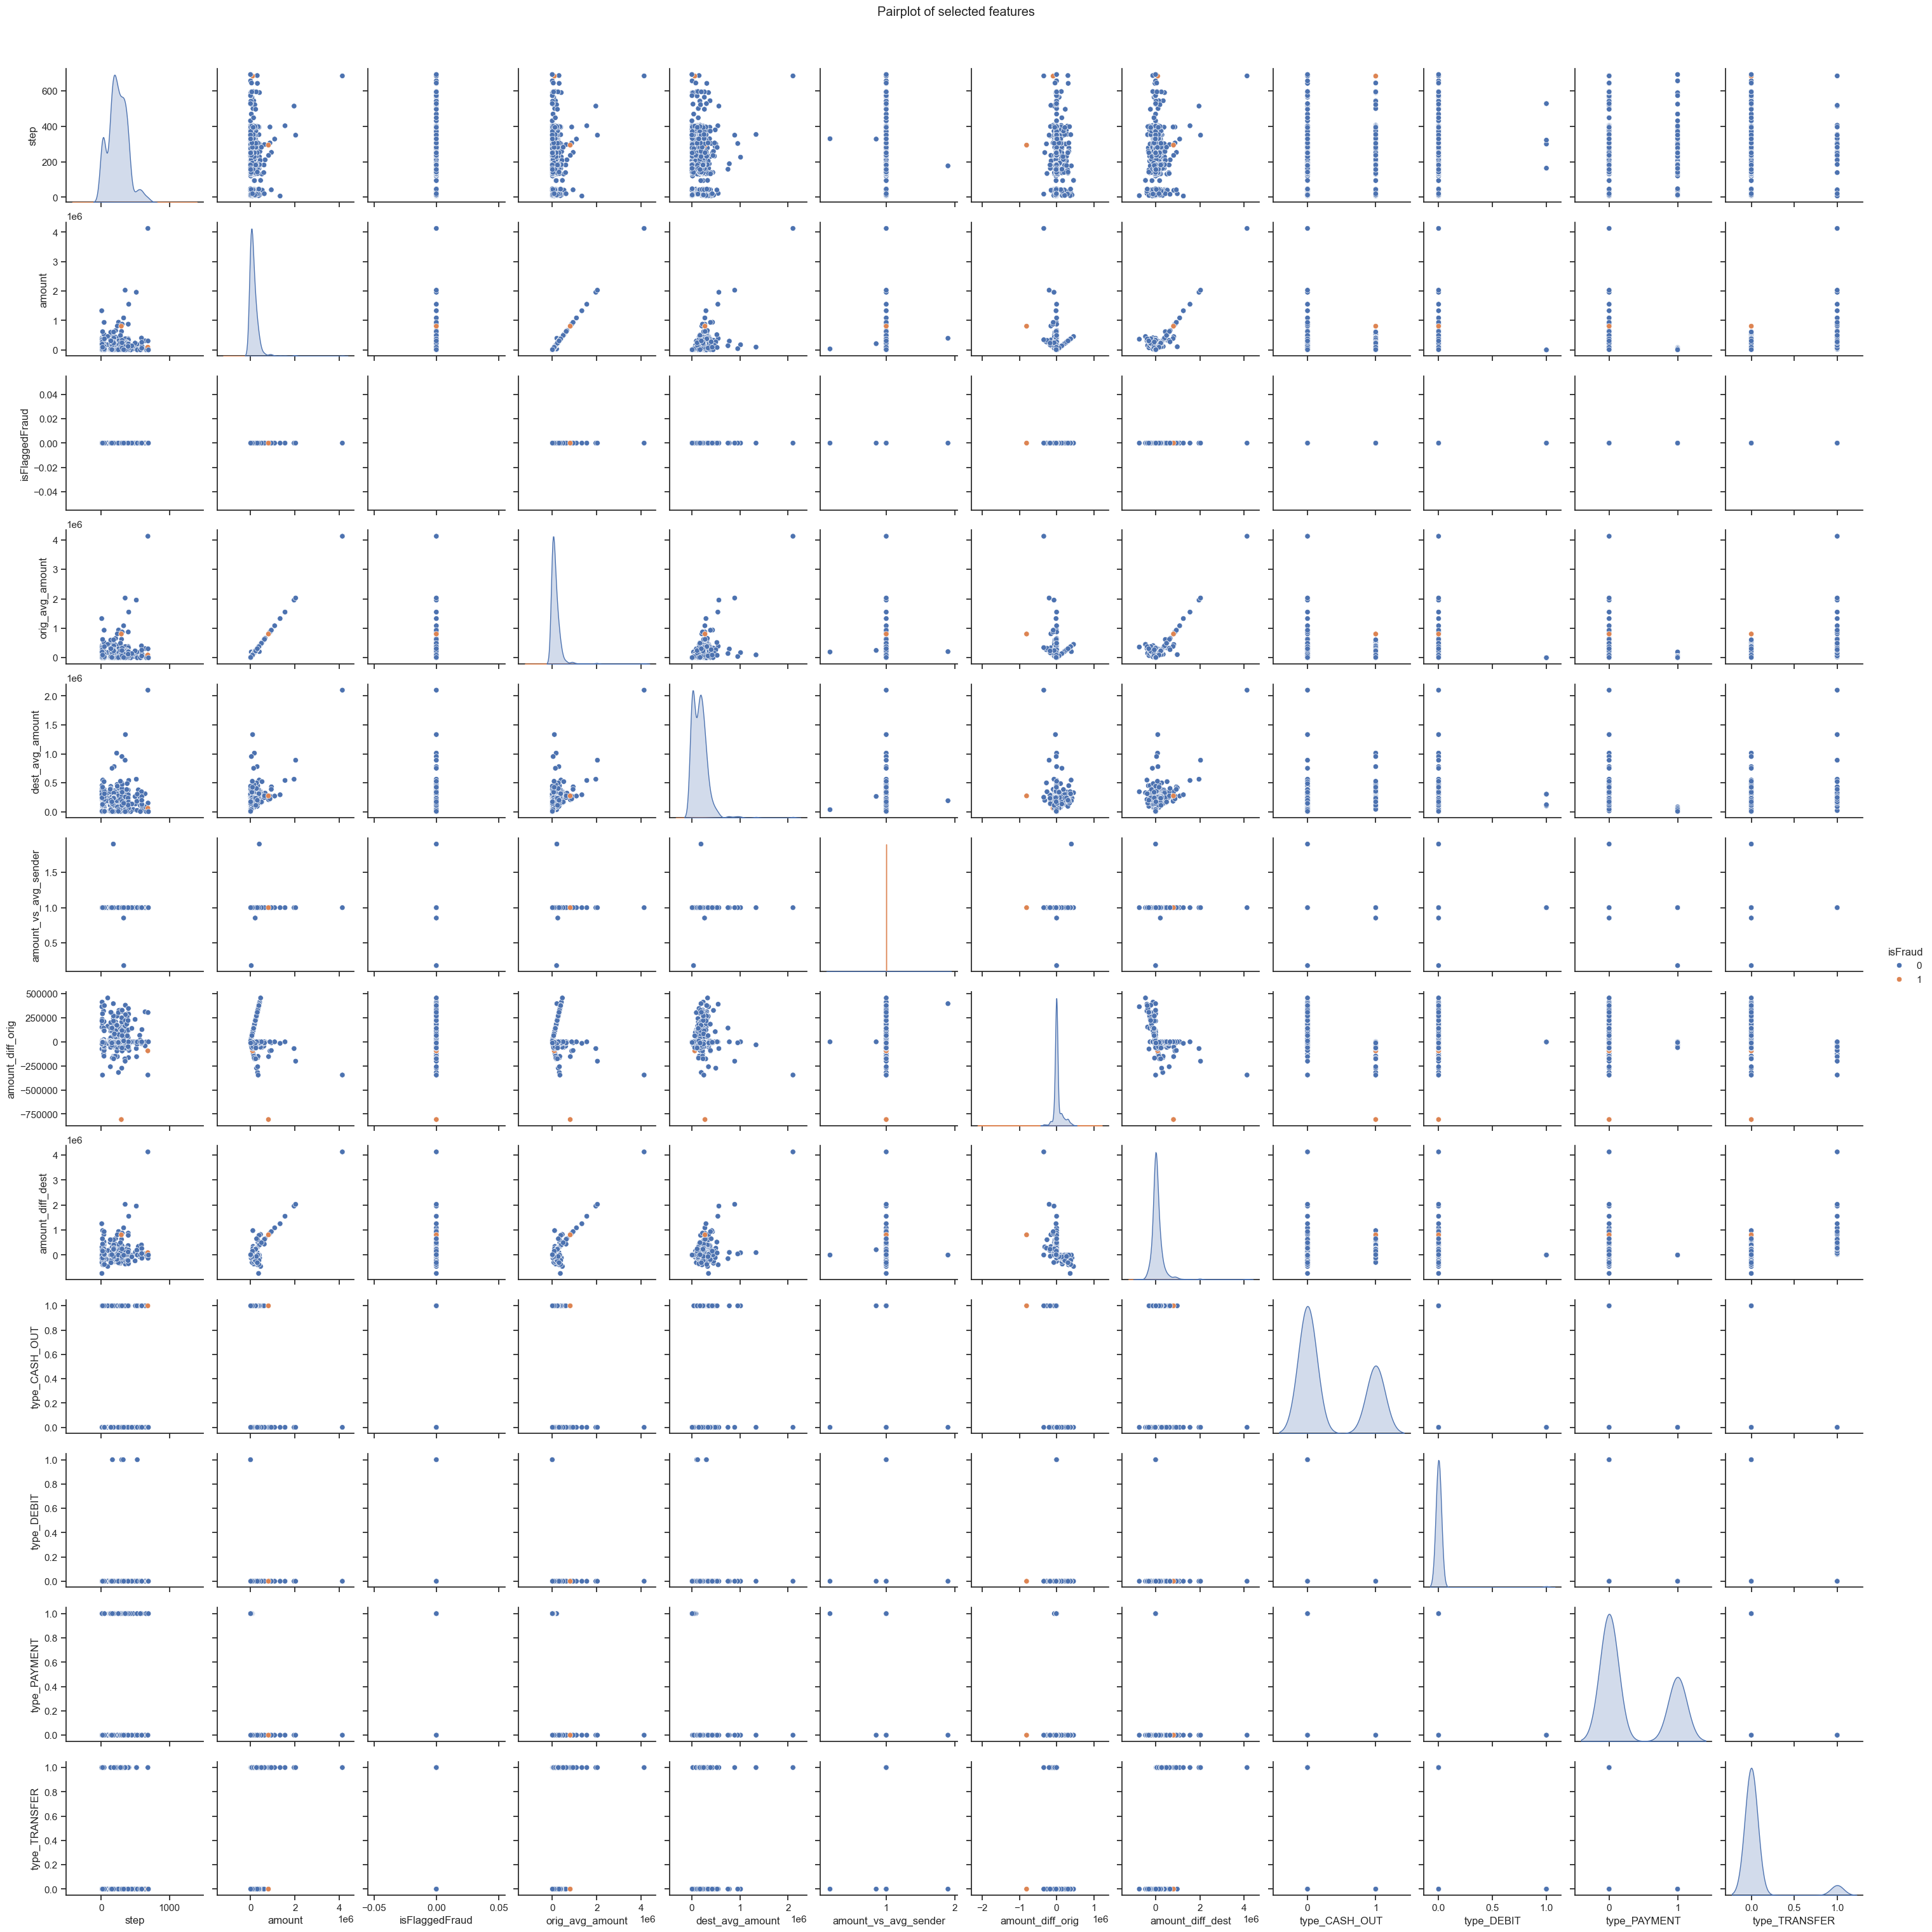

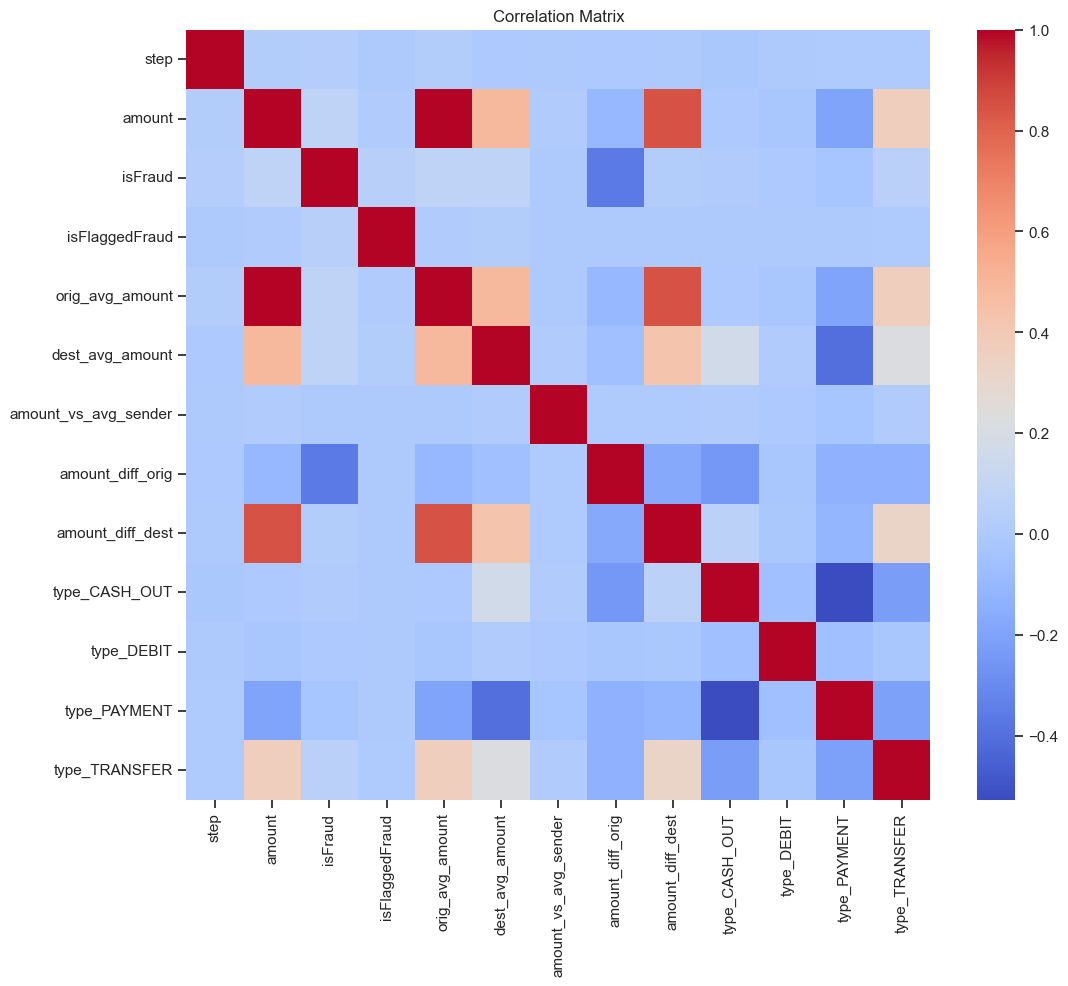

In [9]:
cm = sns.set_theme(style="ticks")
cm = sns.pairplot(df.sample(n=500, random_state=42), hue='isFraud')
plt.suptitle('Pairplot of selected features', y=1.02)
plt.show()

plt.figure(figsize=(12, 10))
correlation = df.corr()
sns.heatmap(correlation, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Split Data

In [10]:
X = df.drop(columns=['isFraud'], errors='ignore')
y = df['isFraud']

train_ratio = data_config['data_ratios']['train']
val_ratio = data_config['data_ratios']['validation']
test_ratio = data_config['data_ratios']['test']
random_state = data_config['data_ratios']['random_state']
target_column = 'isFraud'

In [11]:
# Find split points based on ratios
max_step = df['step'].max()
train_end_step = int(max_step * train_ratio)
val_end_step = int(max_step * (train_ratio + val_ratio))


# Split the data chronologically
train_df = df[df['step'] <= train_end_step]
val_df = df[(df['step'] > train_end_step) & (df['step'] <= val_end_step)]
test_df = df[df['step'] > val_end_step]

# Remove the 'step' column from features
X_train, y_train = train_df.drop(columns=[target_column, 'step']), train_df[target_column]
X_val, y_val = val_df.drop(columns=[target_column, 'step']), val_df[target_column]
X_test, y_test = test_df.drop(columns=[target_column, 'step']), test_df[target_column]

In [12]:
print(f"Train set shape: {X_train.shape}, Fraud: {y_train.sum()} ({y_train.mean():.4f}%)")
print(f"Validation set shape: {X_val.shape}, Fraud: {y_val.sum()} ({y_val.mean():.4f}%)")
print(f"Test set shape: {X_test.shape}, Fraud: {y_test.sum()} ({y_test.mean():.4f}%)")
print("Data splitting complete.")

Train set shape: (6082007, 11), Fraud: 5781 (0.0010%)
Validation set shape: (191147, 11), Fraud: 1180 (0.0062%)
Test set shape: (89466, 11), Fraud: 1252 (0.0140%)
Data splitting complete.


## Scale Feature

In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

numerical_features = X_train.columns.tolist()

scaling_method = data_config['preprocessing_params'].get('scaling_method', 'StandardScaler')
print(f"Scaling numerical features using: {scaling_method}...")

if scaling_method == "StandardScaler":
    scaler = StandardScaler()
elif scaling_method == "MinMaxScaler":
    scaler = MinMaxScaler()
elif scaling_method is None:
    print("No scaling applied.")
else:
    raise ValueError(f"Unsupported scaling method: {scaling_method}")

# Fit scaler only on training data to prevent data leakage
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_val_scaled[numerical_features] = scaler.transform(X_val[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])


Scaling numerical features using: StandardScaler...


## Handling Imbalance

In [14]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

if not data_config.get('preprocessing_params', False).get('handle_imbalanced_data', False):
    print('Imbalance handling not enabled in config. Skipping this step.')
    exit()

imbalance_method = data_config['preprocessing_params'].get('imbalance_method', 'SMOTE')

if imbalance_method == "SMOTE":
    sampling_strategy = data_config['preprocessing_params'].get('smote_sampling_strategy')
    sampler = SMOTE(sampling_strategy=sampling_strategy, random_state=random_state)

elif imbalance_method == "ADASYN":
    sampler = ADASYN(random_state=random_state)
elif imbalance_method == "RandomUnderSampler":
    # Be cautious with undersampling as it discards data
    sampler = RandomUnderSampler(random_state=random_state)
elif imbalance_method == "None":
    print("No resampling applied, but imbalance handling is enabled.")
else:
    raise ValueError(f"Unsupported imbalance method: {imbalance_method}")

X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
print(f"Original training data shape: {X_train.shape}, {y_train.value_counts()}")
print(f"Resampled training data shape: {X_resampled.shape}, {y_resampled.value_counts()}")
print("Imbalance handling complete.")


Original training data shape: (6082007, 11), isFraud
0    6076226
1       5781
Name: count, dtype: int64
Resampled training data shape: (12152452, 11), isFraud
0    6076226
1    6076226
Name: count, dtype: int64
Imbalance handling complete.


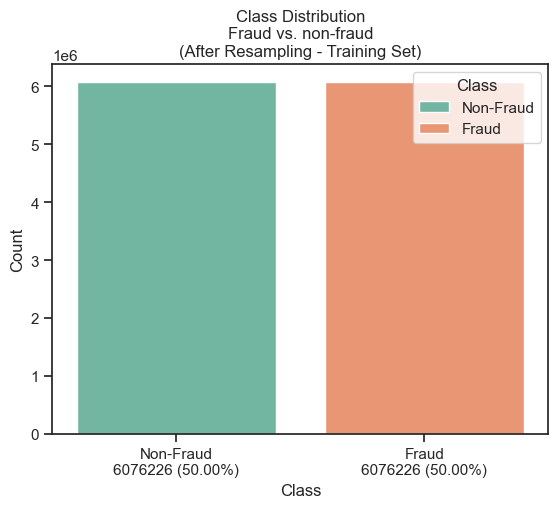

In [15]:
d_length = len(y_resampled)
fraud_count = pd.DataFrame(y_resampled)['isFraud'].sum()
non_fraud_count = d_length - fraud_count

percent_fraud = (fraud_count / d_length) * 100
percent_non_fraud = 100 - percent_fraud

ax = sns.countplot(x='isFraud', data=pd.DataFrame(y_resampled), palette='Set2')
plt.title('Class Distribution\nFraud vs. non-fraud\n(After Resampling - Training Set)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.legend(title='Class', labels=['Non-Fraud', 'Fraud'])
plt.xticks(ticks=[0, 1], labels=[f'Non-Fraud\n{non_fraud_count} ({percent_non_fraud:.2f}%)', f'Fraud\n{fraud_count} ({percent_fraud:.2f}%)'])
plt.show()